In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import sympy
from scipy.interpolate import spline, splrep, BSpline

import operator
from itertools import cycle

from IPython.display import display, clear_output

from sympy import *
init_printing()

from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm


In [2]:
#Symbols
km, ke = symbols('k_m k_e', constant=True, real=True, ) # Proportionality Constants (torque & emf)
Vo, Ve, Tm, Tf = symbols('V_o V_e T_m T_f', constant=True, real=True) # Supplied Voltage, Emf voltage, Motor Torque, Frictional Torque
I, rm, rb = symbols('I r_m r_b', constant=True, real=True) # Current, motor resistance, battery resistance
w = symbols('w', constant=True, real=True) # (omega) motor rotational speed

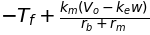

In [3]:
TorqueDef = km * (Vo - w*ke)/(rm + rb) - Tf
TorqueDef

In [4]:
#More symbols
Tnet, rw, E= symbols('T_net r_w, E', constant=True, real=True) # net torque, wheel radius, Wheel efficiency
Iw, m = symbols('I_w m', constant=True, real=True) # Wheel inertia, robot mass
g = symbols('g', constant=True, real=True) # Gear ratio

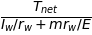

In [5]:
acelDef = Tnet / (rw*m/E + Iw/rw)
acelDef

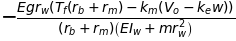

In [6]:
workingAcel = simplify(acelDef.subs(Tnet, TorqueDef * g))
workingAcel

In [7]:
# More Symbols
v = symbols('v', constant=True, real=True) # Robot velocity
wDef = v/(2*math.pi*rw )* 60 * g
vDef = solve(Eq(wDef, w), v)
wDef

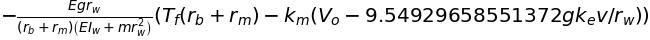

In [8]:
workingAcel2 = workingAcel.subs(w, wDef)
workingAcel2

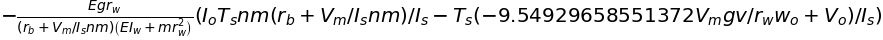

In [9]:
Ts, Is, Io, wo, nm, Vm = symbols('T_s I_s I_o w_o nm V_m', constant=True, real=True) # Stall Torque, Stall Current, Free current, number of motors, nominal voltage
KmDef = Ts / Is
KeDef = Vm / wo
RmDef = Vm / (Is * nm)
TfDef = Ts * Io * nm / Is
workingAcel3 = workingAcel2.subs([(km, KmDef), (ke, KeDef), (rm, RmDef), (Tf, TfDef)])
workingAcel3

In [10]:
def aceleration(vel, gratio):
    return FVAL*gratio + SVAL *gratio*gratio*vel - 9.8

def timeAtRatio(targetDist, ratio):
    assert(not ratio == 0)
    t_acum = 0
    x_acum = 0
    v_acum = 0
    dt= 0.0001
    while x_acum < targetDist:
        a = aceleration(v_acum, ratio)
        v_acum += a*dt
        x_acum += v_acum*dt
        t_acum += dt
        
        if a < 0:
            print('Error: not enough torque at: ' + str(ratio))
            return 0
    return t_acum

def optimalRatio(dist):
    ratio = np.arange(1, 40, 0.01)
    time = [timeAtRatio(dist, r) for r in ratio]
    ind, t = min(enumerate(time), key=operator.itemgetter(1))
    return ratio[ind], t

# Substituting Constants

In [11]:
# Motor Specs
stall_torque = 4.2 / 40 # Stall torque (Nm)
motor_num = 4 # Number of motors
stall_current = 8.5 # Stall current (amps)
no_load_current = 0.2 # No load current (amps)
nominal_voltage = 12 #Nominal voltage (volts)
free_speed = 150 * 40 # Free motor speed (rpm)

# Robot Specs
mass = 0.453592 * 5 # Robot mass (kg)
radius = .0064 # Wheel diameter (m)
inertia = 0.00 # Wheel inertia (Kg m^2)
wheel_efficiency = 0.7 # Wheel efficiency (Mecanum = 0.7, tank = 1)

# Battery Specs
batery_resistance = 0.1 # Battery Resistance (ohms)
operating_voltage = 12.7 # Operating battery voltage (volts)

In [12]:
subListNoMass = [(Ts, stall_torque), (nm, motor_num), (Is, stall_current), (Io, no_load_current), 
                 (Vm, nominal_voltage), (wo, free_speed), (rw, radius), (rb, batery_resistance), 
                 (E, wheel_efficiency), (Vo, operating_voltage), (Iw, inertia)]
subList = [(Ts, stall_torque), (nm, motor_num), (Is, stall_current), (Io, no_load_current), 
                 (Vm, nominal_voltage), (wo, free_speed), (rw, radius), (rb, batery_resistance), 
                 (E, wheel_efficiency), (Vo, operating_voltage), (Iw, inertia), (m, mass)]
acelExp = workingAcel3.subs(subList)

acelMassExp = workingAcel3.subs(subListNoMass)

if wheel_efficiency == 1:
    wheelType = 'Tank Drive'
elif wheel_efficiency == 0.7:
    wheelType = 'Mecanum Drive'
else:
    wheelType = '' + 100 * wheel_efficiency + '% efficiency'

# Integration iteration below

In [13]:
print(acelExp.expand())

FCOMP, SCOMP = acelExp.expand().args
FVAL = float(FCOMP.subs(g, 1))
SVAL = float(SCOMP.subs([(g, 1), (v, 1)]))
print('FVAL:', FCOMP)
print('SVAL:', SCOMP)

-3.92493662471612*g**2*v + 16.2271999392986*g
FVAL: 16.2271999392986*g
SVAL: -3.92493662471612*g**2*v


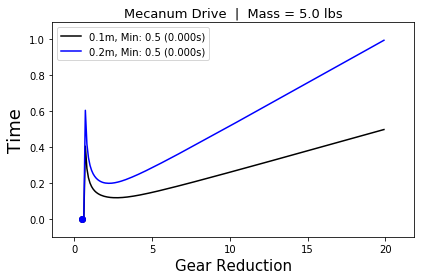

In [14]:
minRatio = 0.5
maxRatio = 20
targetDist = [0.1, 0.2] # meters


colors = cycle(["black", "blue", "grey", "silver", "lime", "green", "olive"])
fig = plt.figure()
ax = fig.add_subplot(111)

ratios = np.arange(minRatio, maxRatio, .1)

for dist in targetDist:
    time = [timeAtRatio(dist, x) for x in ratios]
        
    index, minTime = min(enumerate(time), key=operator.itemgetter(1))
    minRatio = ratios[index]
    color = next(colors)
    
    label = '%.1fm, Min: %.1f (%.3fs)' %(dist, minRatio, minTime)
    ax.plot(ratios, time, label=label, color=color)
    ax.plot(minRatio, minTime, '-o', color=color)
        
clear_output()
    
ax.set_xlabel("Gear Reduction", fontsize=15)
ax.set_ylabel("Time", fontsize=18)
ax.legend(loc="best")
ax.set_title('%s  |  Mass = %.1f lbs' %(wheelType, mass*2.20462), fontsize=13)
ax.margins(0.1)
fig.tight_layout()
plt.show()

# 3D Graph

In [85]:
ratio = np.linspace(1, 40, 100)
dist = np.linspace(0.5, 4, 100)

X, Y = np.meshgrid(dist, ratio)

time = []
for x, y in zip(np.ravel(X), np.ravel(Y)):
    val = timeAtRatio(x, y)
    time.append(val)
    print('(%.2f, %.2f): %.3f' %(x, y, val))
    
nptime = np.array(time)
#time = np.array([timeAtRatio(x,y) for x,y in zip(np.ravel(X), np.ravel(Y))])

Z = nptime.reshape(X.shape)

(0.50, 1.00): 1.763
(0.54, 1.00): 1.825
(0.57, 1.00): 1.884
(0.61, 1.00): 1.942
(0.64, 1.00): 1.998
(0.68, 1.00): 2.053
(0.71, 1.00): 2.106
(0.75, 1.00): 2.158
(0.78, 1.00): 2.208
(0.82, 1.00): 2.258
(0.85, 1.00): 2.306
(0.89, 1.00): 2.354
(0.92, 1.00): 2.400
(0.96, 1.00): 2.446
(0.99, 1.00): 2.491
(1.03, 1.00): 2.535
(1.07, 1.00): 2.578
(1.10, 1.00): 2.621
(1.14, 1.00): 2.663
(1.17, 1.00): 2.704
(1.21, 1.00): 2.745
(1.24, 1.00): 2.785
(1.28, 1.00): 2.824
(1.31, 1.00): 2.863
(1.35, 1.00): 2.902
(1.38, 1.00): 2.940
(1.42, 1.00): 2.977
(1.45, 1.00): 3.014
(1.49, 1.00): 3.051
(1.53, 1.00): 3.087
(1.56, 1.00): 3.123
(1.60, 1.00): 3.158
(1.63, 1.00): 3.193
(1.67, 1.00): 3.227
(1.70, 1.00): 3.262
(1.74, 1.00): 3.296
(1.77, 1.00): 3.329
(1.81, 1.00): 3.362
(1.84, 1.00): 3.395
(1.88, 1.00): 3.428
(1.91, 1.00): 3.460
(1.95, 1.00): 3.492
(1.98, 1.00): 3.524
(2.02, 1.00): 3.555
(2.06, 1.00): 3.586
(2.09, 1.00): 3.617
(2.13, 1.00): 3.648
(2.16, 1.00): 3.678
(2.20, 1.00): 3.708
(2.23, 1.00): 3.738


(1.45, 2.58): 1.907
(1.49, 2.58): 1.931
(1.53, 2.58): 1.954
(1.56, 2.58): 1.977
(1.60, 2.58): 2.000
(1.63, 2.58): 2.022
(1.67, 2.58): 2.045
(1.70, 2.58): 2.067
(1.74, 2.58): 2.089
(1.77, 2.58): 2.110
(1.81, 2.58): 2.132
(1.84, 2.58): 2.153
(1.88, 2.58): 2.174
(1.91, 2.58): 2.195
(1.95, 2.58): 2.216
(1.98, 2.58): 2.236
(2.02, 2.58): 2.256
(2.06, 2.58): 2.276
(2.09, 2.58): 2.296
(2.13, 2.58): 2.316
(2.16, 2.58): 2.336
(2.20, 2.58): 2.355
(2.23, 2.58): 2.375
(2.27, 2.58): 2.394
(2.30, 2.58): 2.413
(2.34, 2.58): 2.432
(2.37, 2.58): 2.451
(2.41, 2.58): 2.470
(2.44, 2.58): 2.488
(2.48, 2.58): 2.506
(2.52, 2.58): 2.525
(2.55, 2.58): 2.543
(2.59, 2.58): 2.561
(2.62, 2.58): 2.579
(2.66, 2.58): 2.597
(2.69, 2.58): 2.614
(2.73, 2.58): 2.632
(2.76, 2.58): 2.650
(2.80, 2.58): 2.667
(2.83, 2.58): 2.684
(2.87, 2.58): 2.701
(2.90, 2.58): 2.718
(2.94, 2.58): 2.735
(2.97, 2.58): 2.752
(3.01, 2.58): 2.769
(3.05, 2.58): 2.786
(3.08, 2.58): 2.802
(3.12, 2.58): 2.819
(3.15, 2.58): 2.835
(3.19, 2.58): 2.852


(2.37, 4.15): 1.986
(2.41, 4.15): 2.001
(2.44, 4.15): 2.017
(2.48, 4.15): 2.032
(2.52, 4.15): 2.047
(2.55, 4.15): 2.062
(2.59, 4.15): 2.077
(2.62, 4.15): 2.092
(2.66, 4.15): 2.107
(2.69, 4.15): 2.122
(2.73, 4.15): 2.137
(2.76, 4.15): 2.152
(2.80, 4.15): 2.166
(2.83, 4.15): 2.181
(2.87, 4.15): 2.195
(2.90, 4.15): 2.209
(2.94, 4.15): 2.224
(2.97, 4.15): 2.238
(3.01, 4.15): 2.252
(3.05, 4.15): 2.266
(3.08, 4.15): 2.280
(3.12, 4.15): 2.294
(3.15, 4.15): 2.308
(3.19, 4.15): 2.321
(3.22, 4.15): 2.335
(3.26, 4.15): 2.349
(3.29, 4.15): 2.362
(3.33, 4.15): 2.376
(3.36, 4.15): 2.389
(3.40, 4.15): 2.403
(3.43, 4.15): 2.416
(3.47, 4.15): 2.429
(3.51, 4.15): 2.442
(3.54, 4.15): 2.455
(3.58, 4.15): 2.468
(3.61, 4.15): 2.481
(3.65, 4.15): 2.494
(3.68, 4.15): 2.507
(3.72, 4.15): 2.520
(3.75, 4.15): 2.533
(3.79, 4.15): 2.546
(3.82, 4.15): 2.558
(3.86, 4.15): 2.571
(3.89, 4.15): 2.584
(3.93, 4.15): 2.596
(3.96, 4.15): 2.609
(4.00, 4.15): 2.621
(0.50, 4.55): 0.848
(0.54, 4.55): 0.879
(0.57, 4.55): 0.908


(3.40, 5.73): 2.135
(3.43, 5.73): 2.147
(3.47, 5.73): 2.159
(3.51, 5.73): 2.172
(3.54, 5.73): 2.184
(3.58, 5.73): 2.196
(3.61, 5.73): 2.208
(3.65, 5.73): 2.220
(3.68, 5.73): 2.232
(3.72, 5.73): 2.244
(3.75, 5.73): 2.256
(3.79, 5.73): 2.268
(3.82, 5.73): 2.280
(3.86, 5.73): 2.292
(3.89, 5.73): 2.303
(3.93, 5.73): 2.315
(3.96, 5.73): 2.327
(4.00, 5.73): 2.338
(0.50, 6.12): 0.743
(0.54, 6.12): 0.770
(0.57, 6.12): 0.796
(0.61, 6.12): 0.822
(0.64, 6.12): 0.847
(0.68, 6.12): 0.871
(0.71, 6.12): 0.895
(0.75, 6.12): 0.918
(0.78, 6.12): 0.941
(0.82, 6.12): 0.963
(0.85, 6.12): 0.985
(0.89, 6.12): 1.006
(0.92, 6.12): 1.027
(0.96, 6.12): 1.048
(0.99, 6.12): 1.068
(1.03, 6.12): 1.088
(1.07, 6.12): 1.108
(1.10, 6.12): 1.127
(1.14, 6.12): 1.147
(1.17, 6.12): 1.166
(1.21, 6.12): 1.184
(1.24, 6.12): 1.203
(1.28, 6.12): 1.221
(1.31, 6.12): 1.239
(1.35, 6.12): 1.257
(1.38, 6.12): 1.275
(1.42, 6.12): 1.292
(1.45, 6.12): 1.309
(1.49, 6.12): 1.326
(1.53, 6.12): 1.343
(1.56, 6.12): 1.360
(1.60, 6.12): 1.377


(1.24, 9.27): 1.043
(1.28, 9.27): 1.060
(1.31, 9.27): 1.077
(1.35, 9.27): 1.094
(1.38, 9.27): 1.110
(1.42, 9.27): 1.126
(1.45, 9.27): 1.142
(1.49, 9.27): 1.158
(1.53, 9.27): 1.174
(1.56, 9.27): 1.190
(1.60, 9.27): 1.206
(1.63, 9.27): 1.221
(1.67, 9.27): 1.237
(1.70, 9.27): 1.252
(1.74, 9.27): 1.267
(1.77, 9.27): 1.282
(1.81, 9.27): 1.297
(1.84, 9.27): 1.312
(1.88, 9.27): 1.327
(1.91, 9.27): 1.342
(1.95, 9.27): 1.356
(1.98, 9.27): 1.371
(2.02, 9.27): 1.385
(2.06, 9.27): 1.400
(2.09, 9.27): 1.414
(2.13, 9.27): 1.428
(2.16, 9.27): 1.442
(2.20, 9.27): 1.457
(2.23, 9.27): 1.471
(2.27, 9.27): 1.485
(2.30, 9.27): 1.498
(2.34, 9.27): 1.512
(2.37, 9.27): 1.526
(2.41, 9.27): 1.540
(2.44, 9.27): 1.553
(2.48, 9.27): 1.567
(2.52, 9.27): 1.581
(2.55, 9.27): 1.594
(2.59, 9.27): 1.607
(2.62, 9.27): 1.621
(2.66, 9.27): 1.634
(2.69, 9.27): 1.647
(2.73, 9.27): 1.661
(2.76, 9.27): 1.674
(2.80, 9.27): 1.687
(2.83, 9.27): 1.700
(2.87, 9.27): 1.713
(2.90, 9.27): 1.726
(2.94, 9.27): 1.739
(2.97, 9.27): 1.752


(2.48, 10.85): 1.535
(2.52, 10.85): 1.549
(2.55, 10.85): 1.563
(2.59, 10.85): 1.577
(2.62, 10.85): 1.591
(2.66, 10.85): 1.605
(2.69, 10.85): 1.618
(2.73, 10.85): 1.632
(2.76, 10.85): 1.646
(2.80, 10.85): 1.660
(2.83, 10.85): 1.673
(2.87, 10.85): 1.687
(2.90, 10.85): 1.700
(2.94, 10.85): 1.714
(2.97, 10.85): 1.727
(3.01, 10.85): 1.741
(3.05, 10.85): 1.754
(3.08, 10.85): 1.768
(3.12, 10.85): 1.781
(3.15, 10.85): 1.794
(3.19, 10.85): 1.808
(3.22, 10.85): 1.821
(3.26, 10.85): 1.834
(3.29, 10.85): 1.847
(3.33, 10.85): 1.861
(3.36, 10.85): 1.874
(3.40, 10.85): 1.887
(3.43, 10.85): 1.900
(3.47, 10.85): 1.913
(3.51, 10.85): 1.926
(3.54, 10.85): 1.939
(3.58, 10.85): 1.952
(3.61, 10.85): 1.965
(3.65, 10.85): 1.978
(3.68, 10.85): 1.991
(3.72, 10.85): 2.004
(3.75, 10.85): 2.017
(3.79, 10.85): 2.030
(3.82, 10.85): 2.043
(3.86, 10.85): 2.056
(3.89, 10.85): 2.068
(3.93, 10.85): 2.081
(3.96, 10.85): 2.094
(4.00, 10.85): 2.107
(0.50, 11.24): 0.588
(0.54, 11.24): 0.611
(0.57, 11.24): 0.633
(0.61, 11.24)

(2.97, 12.42): 1.734
(3.01, 12.42): 1.748
(3.05, 12.42): 1.763
(3.08, 12.42): 1.777
(3.12, 12.42): 1.791
(3.15, 12.42): 1.806
(3.19, 12.42): 1.820
(3.22, 12.42): 1.834
(3.26, 12.42): 1.848
(3.29, 12.42): 1.862
(3.33, 12.42): 1.877
(3.36, 12.42): 1.891
(3.40, 12.42): 1.905
(3.43, 12.42): 1.919
(3.47, 12.42): 1.933
(3.51, 12.42): 1.947
(3.54, 12.42): 1.961
(3.58, 12.42): 1.975
(3.61, 12.42): 1.989
(3.65, 12.42): 2.003
(3.68, 12.42): 2.017
(3.72, 12.42): 2.031
(3.75, 12.42): 2.045
(3.79, 12.42): 2.059
(3.82, 12.42): 2.073
(3.86, 12.42): 2.087
(3.89, 12.42): 2.101
(3.93, 12.42): 2.115
(3.96, 12.42): 2.129
(4.00, 12.42): 2.143
(0.50, 12.82): 0.565
(0.54, 12.82): 0.588
(0.57, 12.82): 0.610
(0.61, 12.82): 0.632
(0.64, 12.82): 0.653
(0.68, 12.82): 0.674
(0.71, 12.82): 0.695
(0.75, 12.82): 0.715
(0.78, 12.82): 0.735
(0.82, 12.82): 0.755
(0.85, 12.82): 0.774
(0.89, 12.82): 0.793
(0.92, 12.82): 0.812
(0.96, 12.82): 0.831
(0.99, 12.82): 0.850
(1.03, 12.82): 0.868
(1.07, 12.82): 0.886
(1.10, 12.82)

(2.80, 14.00): 1.688
(2.83, 14.00): 1.704
(2.87, 14.00): 1.720
(2.90, 14.00): 1.735
(2.94, 14.00): 1.751
(2.97, 14.00): 1.766
(3.01, 14.00): 1.782
(3.05, 14.00): 1.797
(3.08, 14.00): 1.813
(3.12, 14.00): 1.828
(3.15, 14.00): 1.844
(3.19, 14.00): 1.859
(3.22, 14.00): 1.875
(3.26, 14.00): 1.890
(3.29, 14.00): 1.906
(3.33, 14.00): 1.921
(3.36, 14.00): 1.936
(3.40, 14.00): 1.952
(3.43, 14.00): 1.967
(3.47, 14.00): 1.983
(3.51, 14.00): 1.998
(3.54, 14.00): 2.013
(3.58, 14.00): 2.029
(3.61, 14.00): 2.044
(3.65, 14.00): 2.059
(3.68, 14.00): 2.075
(3.72, 14.00): 2.090
(3.75, 14.00): 2.105
(3.79, 14.00): 2.121
(3.82, 14.00): 2.136
(3.86, 14.00): 2.151
(3.89, 14.00): 2.166
(3.93, 14.00): 2.182
(3.96, 14.00): 2.197
(4.00, 14.00): 2.212
(0.50, 14.39): 0.549
(0.54, 14.39): 0.572
(0.57, 14.39): 0.594
(0.61, 14.39): 0.616
(0.64, 14.39): 0.637
(0.68, 14.39): 0.658
(0.71, 14.39): 0.679
(0.75, 14.39): 0.700
(0.78, 14.39): 0.720
(0.82, 14.39): 0.740
(0.85, 14.39): 0.760
(0.89, 14.39): 0.779
(0.92, 14.39)

(2.55, 15.58): 1.617
(2.59, 15.58): 1.634
(2.62, 15.58): 1.651
(2.66, 15.58): 1.668
(2.69, 15.58): 1.685
(2.73, 15.58): 1.702
(2.76, 15.58): 1.719
(2.80, 15.58): 1.736
(2.83, 15.58): 1.753
(2.87, 15.58): 1.770
(2.90, 15.58): 1.787
(2.94, 15.58): 1.804
(2.97, 15.58): 1.821
(3.01, 15.58): 1.838
(3.05, 15.58): 1.855
(3.08, 15.58): 1.871
(3.12, 15.58): 1.888
(3.15, 15.58): 1.905
(3.19, 15.58): 1.922
(3.22, 15.58): 1.939
(3.26, 15.58): 1.956
(3.29, 15.58): 1.973
(3.33, 15.58): 1.990
(3.36, 15.58): 2.007
(3.40, 15.58): 2.023
(3.43, 15.58): 2.040
(3.47, 15.58): 2.057
(3.51, 15.58): 2.074
(3.54, 15.58): 2.091
(3.58, 15.58): 2.108
(3.61, 15.58): 2.124
(3.65, 15.58): 2.141
(3.68, 15.58): 2.158
(3.72, 15.58): 2.175
(3.75, 15.58): 2.192
(3.79, 15.58): 2.209
(3.82, 15.58): 2.225
(3.86, 15.58): 2.242
(3.89, 15.58): 2.259
(3.93, 15.58): 2.276
(3.96, 15.58): 2.292
(4.00, 15.58): 2.309
(0.50, 15.97): 0.538
(0.54, 15.97): 0.561
(0.57, 15.97): 0.583
(0.61, 15.97): 0.605
(0.64, 15.97): 0.627
(0.68, 15.97)

(2.62, 17.15): 1.708
(2.66, 17.15): 1.727
(2.69, 17.15): 1.745
(2.73, 17.15): 1.764
(2.76, 17.15): 1.782
(2.80, 17.15): 1.801
(2.83, 17.15): 1.819
(2.87, 17.15): 1.838
(2.90, 17.15): 1.856
(2.94, 17.15): 1.875
(2.97, 17.15): 1.893
(3.01, 17.15): 1.912
(3.05, 17.15): 1.930
(3.08, 17.15): 1.949
(3.12, 17.15): 1.967
(3.15, 17.15): 1.986
(3.19, 17.15): 2.004
(3.22, 17.15): 2.023
(3.26, 17.15): 2.041
(3.29, 17.15): 2.060
(3.33, 17.15): 2.078
(3.36, 17.15): 2.096
(3.40, 17.15): 2.115
(3.43, 17.15): 2.133
(3.47, 17.15): 2.152
(3.51, 17.15): 2.170
(3.54, 17.15): 2.189
(3.58, 17.15): 2.207
(3.61, 17.15): 2.226
(3.65, 17.15): 2.244
(3.68, 17.15): 2.263
(3.72, 17.15): 2.281
(3.75, 17.15): 2.299
(3.79, 17.15): 2.318
(3.82, 17.15): 2.336
(3.86, 17.15): 2.355
(3.89, 17.15): 2.373
(3.93, 17.15): 2.392
(3.96, 17.15): 2.410
(4.00, 17.15): 2.428
(0.50, 17.55): 0.531
(0.54, 17.55): 0.554
(0.57, 17.55): 0.577
(0.61, 17.55): 0.600
(0.64, 17.55): 0.622
(0.68, 17.55): 0.644
(0.71, 17.55): 0.666
(0.75, 17.55)

(2.34, 18.73): 1.618
(2.37, 18.73): 1.639
(2.41, 18.73): 1.659
(2.44, 18.73): 1.679
(2.48, 18.73): 1.699
(2.52, 18.73): 1.719
(2.55, 18.73): 1.739
(2.59, 18.73): 1.760
(2.62, 18.73): 1.780
(2.66, 18.73): 1.800
(2.69, 18.73): 1.820
(2.73, 18.73): 1.840
(2.76, 18.73): 1.860
(2.80, 18.73): 1.880
(2.83, 18.73): 1.900
(2.87, 18.73): 1.921
(2.90, 18.73): 1.941
(2.94, 18.73): 1.961
(2.97, 18.73): 1.981
(3.01, 18.73): 2.001
(3.05, 18.73): 2.021
(3.08, 18.73): 2.041
(3.12, 18.73): 2.061
(3.15, 18.73): 2.082
(3.19, 18.73): 2.102
(3.22, 18.73): 2.122
(3.26, 18.73): 2.142
(3.29, 18.73): 2.162
(3.33, 18.73): 2.182
(3.36, 18.73): 2.202
(3.40, 18.73): 2.222
(3.43, 18.73): 2.243
(3.47, 18.73): 2.263
(3.51, 18.73): 2.283
(3.54, 18.73): 2.303
(3.58, 18.73): 2.323
(3.61, 18.73): 2.343
(3.65, 18.73): 2.363
(3.68, 18.73): 2.383
(3.72, 18.73): 2.403
(3.75, 18.73): 2.423
(3.79, 18.73): 2.444
(3.82, 18.73): 2.464
(3.86, 18.73): 2.484
(3.89, 18.73): 2.504
(3.93, 18.73): 2.524
(3.96, 18.73): 2.544
(4.00, 18.73)

(2.52, 20.30): 1.797
(2.55, 20.30): 1.819
(2.59, 20.30): 1.840
(2.62, 20.30): 1.862
(2.66, 20.30): 1.884
(2.69, 20.30): 1.906
(2.73, 20.30): 1.928
(2.76, 20.30): 1.949
(2.80, 20.30): 1.971
(2.83, 20.30): 1.993
(2.87, 20.30): 2.015
(2.90, 20.30): 2.037
(2.94, 20.30): 2.058
(2.97, 20.30): 2.080
(3.01, 20.30): 2.102
(3.05, 20.30): 2.124
(3.08, 20.30): 2.146
(3.12, 20.30): 2.167
(3.15, 20.30): 2.189
(3.19, 20.30): 2.211
(3.22, 20.30): 2.233
(3.26, 20.30): 2.255
(3.29, 20.30): 2.276
(3.33, 20.30): 2.298
(3.36, 20.30): 2.320
(3.40, 20.30): 2.342
(3.43, 20.30): 2.364
(3.47, 20.30): 2.385
(3.51, 20.30): 2.407
(3.54, 20.30): 2.429
(3.58, 20.30): 2.451
(3.61, 20.30): 2.472
(3.65, 20.30): 2.494
(3.68, 20.30): 2.516
(3.72, 20.30): 2.538
(3.75, 20.30): 2.560
(3.79, 20.30): 2.581
(3.82, 20.30): 2.603
(3.86, 20.30): 2.625
(3.89, 20.30): 2.647
(3.93, 20.30): 2.669
(3.96, 20.30): 2.690
(4.00, 20.30): 2.712
(0.50, 20.70): 0.526
(0.54, 20.70): 0.551
(0.57, 20.70): 0.575
(0.61, 20.70): 0.599
(0.64, 20.70)

(2.41, 21.88): 1.813
(2.44, 21.88): 1.836
(2.48, 21.88): 1.859
(2.52, 21.88): 1.883
(2.55, 21.88): 1.906
(2.59, 21.88): 1.930
(2.62, 21.88): 1.953
(2.66, 21.88): 1.977
(2.69, 21.88): 2.000
(2.73, 21.88): 2.024
(2.76, 21.88): 2.047
(2.80, 21.88): 2.071
(2.83, 21.88): 2.094
(2.87, 21.88): 2.118
(2.90, 21.88): 2.141
(2.94, 21.88): 2.165
(2.97, 21.88): 2.188
(3.01, 21.88): 2.212
(3.05, 21.88): 2.235
(3.08, 21.88): 2.259
(3.12, 21.88): 2.282
(3.15, 21.88): 2.306
(3.19, 21.88): 2.329
(3.22, 21.88): 2.353
(3.26, 21.88): 2.376
(3.29, 21.88): 2.400
(3.33, 21.88): 2.423
(3.36, 21.88): 2.447
(3.40, 21.88): 2.470
(3.43, 21.88): 2.494
(3.47, 21.88): 2.517
(3.51, 21.88): 2.540
(3.54, 21.88): 2.564
(3.58, 21.88): 2.587
(3.61, 21.88): 2.611
(3.65, 21.88): 2.634
(3.68, 21.88): 2.658
(3.72, 21.88): 2.681
(3.75, 21.88): 2.705
(3.79, 21.88): 2.728
(3.82, 21.88): 2.752
(3.86, 21.88): 2.775
(3.89, 21.88): 2.799
(3.93, 21.88): 2.822
(3.96, 21.88): 2.846
(4.00, 21.88): 2.869
(0.50, 22.27): 0.528
(0.54, 22.27)

(2.55, 23.45): 2.001
(2.59, 23.45): 2.026
(2.62, 23.45): 2.051
(2.66, 23.45): 2.076
(2.69, 23.45): 2.102
(2.73, 23.45): 2.127
(2.76, 23.45): 2.152
(2.80, 23.45): 2.177
(2.83, 23.45): 2.202
(2.87, 23.45): 2.227
(2.90, 23.45): 2.253
(2.94, 23.45): 2.278
(2.97, 23.45): 2.303
(3.01, 23.45): 2.328
(3.05, 23.45): 2.353
(3.08, 23.45): 2.378
(3.12, 23.45): 2.404
(3.15, 23.45): 2.429
(3.19, 23.45): 2.454
(3.22, 23.45): 2.479
(3.26, 23.45): 2.504
(3.29, 23.45): 2.529
(3.33, 23.45): 2.555
(3.36, 23.45): 2.580
(3.40, 23.45): 2.605
(3.43, 23.45): 2.630
(3.47, 23.45): 2.655
(3.51, 23.45): 2.680
(3.54, 23.45): 2.706
(3.58, 23.45): 2.731
(3.61, 23.45): 2.756
(3.65, 23.45): 2.781
(3.68, 23.45): 2.806
(3.72, 23.45): 2.831
(3.75, 23.45): 2.857
(3.79, 23.45): 2.882
(3.82, 23.45): 2.907
(3.86, 23.45): 2.932
(3.89, 23.45): 2.957
(3.93, 23.45): 2.982
(3.96, 23.45): 3.008
(4.00, 23.45): 3.033
(0.50, 23.85): 0.532
(0.54, 23.85): 0.559
(0.57, 23.85): 0.585
(0.61, 23.85): 0.612
(0.64, 23.85): 0.638
(0.68, 23.85)

(3.01, 25.03): 2.449
(3.05, 25.03): 2.476
(3.08, 25.03): 2.503
(3.12, 25.03): 2.530
(3.15, 25.03): 2.557
(3.19, 25.03): 2.584
(3.22, 25.03): 2.611
(3.26, 25.03): 2.638
(3.29, 25.03): 2.664
(3.33, 25.03): 2.691
(3.36, 25.03): 2.718
(3.40, 25.03): 2.745
(3.43, 25.03): 2.772
(3.47, 25.03): 2.799
(3.51, 25.03): 2.826
(3.54, 25.03): 2.852
(3.58, 25.03): 2.879
(3.61, 25.03): 2.906
(3.65, 25.03): 2.933
(3.68, 25.03): 2.960
(3.72, 25.03): 2.987
(3.75, 25.03): 3.014
(3.79, 25.03): 3.040
(3.82, 25.03): 3.067
(3.86, 25.03): 3.094
(3.89, 25.03): 3.121
(3.93, 25.03): 3.148
(3.96, 25.03): 3.175
(4.00, 25.03): 3.202
(0.50, 25.42): 0.538
(0.54, 25.42): 0.566
(0.57, 25.42): 0.594
(0.61, 25.42): 0.622
(0.64, 25.42): 0.650
(0.68, 25.42): 0.678
(0.71, 25.42): 0.705
(0.75, 25.42): 0.733
(0.78, 25.42): 0.760
(0.82, 25.42): 0.788
(0.85, 25.42): 0.815
(0.89, 25.42): 0.843
(0.92, 25.42): 0.870
(0.96, 25.42): 0.897
(0.99, 25.42): 0.925
(1.03, 25.42): 0.952
(1.07, 25.42): 0.980
(1.10, 25.42): 1.007
(1.14, 25.42)

(2.76, 26.61): 2.375
(2.80, 26.61): 2.403
(2.83, 26.61): 2.432
(2.87, 26.61): 2.461
(2.90, 26.61): 2.489
(2.94, 26.61): 2.518
(2.97, 26.61): 2.546
(3.01, 26.61): 2.575
(3.05, 26.61): 2.603
(3.08, 26.61): 2.632
(3.12, 26.61): 2.660
(3.15, 26.61): 2.689
(3.19, 26.61): 2.718
(3.22, 26.61): 2.746
(3.26, 26.61): 2.775
(3.29, 26.61): 2.803
(3.33, 26.61): 2.832
(3.36, 26.61): 2.860
(3.40, 26.61): 2.889
(3.43, 26.61): 2.917
(3.47, 26.61): 2.946
(3.51, 26.61): 2.974
(3.54, 26.61): 3.003
(3.58, 26.61): 3.032
(3.61, 26.61): 3.060
(3.65, 26.61): 3.089
(3.68, 26.61): 3.117
(3.72, 26.61): 3.146
(3.75, 26.61): 3.174
(3.79, 26.61): 3.203
(3.82, 26.61): 3.231
(3.86, 26.61): 3.260
(3.89, 26.61): 3.289
(3.93, 26.61): 3.317
(3.96, 26.61): 3.346
(4.00, 26.61): 3.374
(0.50, 27.00): 0.547
(0.54, 27.00): 0.576
(0.57, 27.00): 0.606
(0.61, 27.00): 0.635
(0.64, 27.00): 0.664
(0.68, 27.00): 0.693
(0.71, 27.00): 0.722
(0.75, 27.00): 0.752
(0.78, 27.00): 0.781
(0.82, 27.00): 0.810
(0.85, 27.00): 0.839
(0.89, 27.00)

(2.97, 28.18): 2.673
(3.01, 28.18): 2.703
(3.05, 28.18): 2.733
(3.08, 28.18): 2.764
(3.12, 28.18): 2.794
(3.15, 28.18): 2.824
(3.19, 28.18): 2.854
(3.22, 28.18): 2.885
(3.26, 28.18): 2.915
(3.29, 28.18): 2.945
(3.33, 28.18): 2.975
(3.36, 28.18): 3.006
(3.40, 28.18): 3.036
(3.43, 28.18): 3.066
(3.47, 28.18): 3.096
(3.51, 28.18): 3.126
(3.54, 28.18): 3.157
(3.58, 28.18): 3.187
(3.61, 28.18): 3.217
(3.65, 28.18): 3.247
(3.68, 28.18): 3.278
(3.72, 28.18): 3.308
(3.75, 28.18): 3.338
(3.79, 28.18): 3.368
(3.82, 28.18): 3.399
(3.86, 28.18): 3.429
(3.89, 28.18): 3.459
(3.93, 28.18): 3.489
(3.96, 28.18): 3.520
(4.00, 28.18): 3.550
(0.50, 28.58): 0.557
(0.54, 28.58): 0.588
(0.57, 28.58): 0.619
(0.61, 28.58): 0.650
(0.64, 28.58): 0.680
(0.68, 28.58): 0.711
(0.71, 28.58): 0.742
(0.75, 28.58): 0.773
(0.78, 28.58): 0.803
(0.82, 28.58): 0.834
(0.85, 28.58): 0.865
(0.89, 28.58): 0.896
(0.92, 28.58): 0.926
(0.96, 28.58): 0.957
(0.99, 28.58): 0.988
(1.03, 28.58): 1.018
(1.07, 28.58): 1.049
(1.10, 28.58)

(2.97, 29.76): 2.802
(3.01, 29.76): 2.834
(3.05, 29.76): 2.866
(3.08, 29.76): 2.898
(3.12, 29.76): 2.930
(3.15, 29.76): 2.962
(3.19, 29.76): 2.994
(3.22, 29.76): 3.025
(3.26, 29.76): 3.057
(3.29, 29.76): 3.089
(3.33, 29.76): 3.121
(3.36, 29.76): 3.153
(3.40, 29.76): 3.185
(3.43, 29.76): 3.217
(3.47, 29.76): 3.249
(3.51, 29.76): 3.281
(3.54, 29.76): 3.313
(3.58, 29.76): 3.345
(3.61, 29.76): 3.377
(3.65, 29.76): 3.409
(3.68, 29.76): 3.441
(3.72, 29.76): 3.472
(3.75, 29.76): 3.504
(3.79, 29.76): 3.536
(3.82, 29.76): 3.568
(3.86, 29.76): 3.600
(3.89, 29.76): 3.632
(3.93, 29.76): 3.664
(3.96, 29.76): 3.696
(4.00, 29.76): 3.728
(0.50, 30.15): 0.569
(0.54, 30.15): 0.601
(0.57, 30.15): 0.634
(0.61, 30.15): 0.666
(0.64, 30.15): 0.699
(0.68, 30.15): 0.731
(0.71, 30.15): 0.764
(0.75, 30.15): 0.796
(0.78, 30.15): 0.828
(0.82, 30.15): 0.861
(0.85, 30.15): 0.893
(0.89, 30.15): 0.925
(0.92, 30.15): 0.958
(0.96, 30.15): 0.990
(0.99, 30.15): 1.023
(1.03, 30.15): 1.055
(1.07, 30.15): 1.087
(1.10, 30.15)

(2.83, 31.33): 2.798
(2.87, 31.33): 2.832
(2.90, 31.33): 2.866
(2.94, 31.33): 2.899
(2.97, 31.33): 2.933
(3.01, 31.33): 2.967
(3.05, 31.33): 3.000
(3.08, 31.33): 3.034
(3.12, 31.33): 3.067
(3.15, 31.33): 3.101
(3.19, 31.33): 3.135
(3.22, 31.33): 3.168
(3.26, 31.33): 3.202
(3.29, 31.33): 3.236
(3.33, 31.33): 3.269
(3.36, 31.33): 3.303
(3.40, 31.33): 3.336
(3.43, 31.33): 3.370
(3.47, 31.33): 3.404
(3.51, 31.33): 3.437
(3.54, 31.33): 3.471
(3.58, 31.33): 3.505
(3.61, 31.33): 3.538
(3.65, 31.33): 3.572
(3.68, 31.33): 3.605
(3.72, 31.33): 3.639
(3.75, 31.33): 3.673
(3.79, 31.33): 3.706
(3.82, 31.33): 3.740
(3.86, 31.33): 3.773
(3.89, 31.33): 3.807
(3.93, 31.33): 3.841
(3.96, 31.33): 3.874
(4.00, 31.33): 3.908
(0.50, 31.73): 0.582
(0.54, 31.73): 0.616
(0.57, 31.73): 0.651
(0.61, 31.73): 0.685
(0.64, 31.73): 0.719
(0.68, 31.73): 0.753
(0.71, 31.73): 0.787
(0.75, 31.73): 0.821
(0.78, 31.73): 0.855
(0.82, 31.73): 0.889
(0.85, 31.73): 0.923
(0.89, 31.73): 0.957
(0.92, 31.73): 0.991
(0.96, 31.73)

(2.83, 32.91): 2.924
(2.87, 32.91): 2.960
(2.90, 32.91): 2.995
(2.94, 32.91): 3.030
(2.97, 32.91): 3.065
(3.01, 32.91): 3.101
(3.05, 32.91): 3.136
(3.08, 32.91): 3.171
(3.12, 32.91): 3.207
(3.15, 32.91): 3.242
(3.19, 32.91): 3.277
(3.22, 32.91): 3.313
(3.26, 32.91): 3.348
(3.29, 32.91): 3.383
(3.33, 32.91): 3.419
(3.36, 32.91): 3.454
(3.40, 32.91): 3.489
(3.43, 32.91): 3.525
(3.47, 32.91): 3.560
(3.51, 32.91): 3.595
(3.54, 32.91): 3.631
(3.58, 32.91): 3.666
(3.61, 32.91): 3.701
(3.65, 32.91): 3.736
(3.68, 32.91): 3.772
(3.72, 32.91): 3.807
(3.75, 32.91): 3.842
(3.79, 32.91): 3.878
(3.82, 32.91): 3.913
(3.86, 32.91): 3.948
(3.89, 32.91): 3.984
(3.93, 32.91): 4.019
(3.96, 32.91): 4.054
(4.00, 32.91): 4.090
(0.50, 33.30): 0.597
(0.54, 33.30): 0.633
(0.57, 33.30): 0.669
(0.61, 33.30): 0.704
(0.64, 33.30): 0.740
(0.68, 33.30): 0.776
(0.71, 33.30): 0.812
(0.75, 33.30): 0.847
(0.78, 33.30): 0.883
(0.82, 33.30): 0.919
(0.85, 33.30): 0.955
(0.89, 33.30): 0.990
(0.92, 33.30): 1.026
(0.96, 33.30)

(2.59, 34.48): 2.792
(2.62, 34.48): 2.829
(2.66, 34.48): 2.866
(2.69, 34.48): 2.903
(2.73, 34.48): 2.940
(2.76, 34.48): 2.977
(2.80, 34.48): 3.014
(2.83, 34.48): 3.051
(2.87, 34.48): 3.088
(2.90, 34.48): 3.125
(2.94, 34.48): 3.162
(2.97, 34.48): 3.199
(3.01, 34.48): 3.236
(3.05, 34.48): 3.273
(3.08, 34.48): 3.310
(3.12, 34.48): 3.347
(3.15, 34.48): 3.384
(3.19, 34.48): 3.421
(3.22, 34.48): 3.458
(3.26, 34.48): 3.495
(3.29, 34.48): 3.532
(3.33, 34.48): 3.569
(3.36, 34.48): 3.606
(3.40, 34.48): 3.643
(3.43, 34.48): 3.680
(3.47, 34.48): 3.717
(3.51, 34.48): 3.754
(3.54, 34.48): 3.791
(3.58, 34.48): 3.828
(3.61, 34.48): 3.865
(3.65, 34.48): 3.902
(3.68, 34.48): 3.939
(3.72, 34.48): 3.976
(3.75, 34.48): 4.013
(3.79, 34.48): 4.050
(3.82, 34.48): 4.087
(3.86, 34.48): 4.124
(3.89, 34.48): 4.161
(3.93, 34.48): 4.199
(3.96, 34.48): 4.236
(4.00, 34.48): 4.273
(0.50, 34.88): 0.613
(0.54, 34.88): 0.650
(0.57, 34.88): 0.688
(0.61, 34.88): 0.725
(0.64, 34.88): 0.763
(0.68, 34.88): 0.800
(0.71, 34.88)

(2.59, 36.06): 2.909
(2.62, 36.06): 2.947
(2.66, 36.06): 2.986
(2.69, 36.06): 3.025
(2.73, 36.06): 3.063
(2.76, 36.06): 3.102
(2.80, 36.06): 3.141
(2.83, 36.06): 3.180
(2.87, 36.06): 3.218
(2.90, 36.06): 3.257
(2.94, 36.06): 3.296
(2.97, 36.06): 3.334
(3.01, 36.06): 3.373
(3.05, 36.06): 3.412
(3.08, 36.06): 3.450
(3.12, 36.06): 3.489
(3.15, 36.06): 3.528
(3.19, 36.06): 3.566
(3.22, 36.06): 3.605
(3.26, 36.06): 3.644
(3.29, 36.06): 3.683
(3.33, 36.06): 3.721
(3.36, 36.06): 3.760
(3.40, 36.06): 3.799
(3.43, 36.06): 3.837
(3.47, 36.06): 3.876
(3.51, 36.06): 3.915
(3.54, 36.06): 3.953
(3.58, 36.06): 3.992
(3.61, 36.06): 4.031
(3.65, 36.06): 4.070
(3.68, 36.06): 4.108
(3.72, 36.06): 4.147
(3.75, 36.06): 4.186
(3.79, 36.06): 4.224
(3.82, 36.06): 4.263
(3.86, 36.06): 4.302
(3.89, 36.06): 4.340
(3.93, 36.06): 4.379
(3.96, 36.06): 4.418
(4.00, 36.06): 4.457
(0.50, 36.45): 0.630
(0.54, 36.45): 0.669
(0.57, 36.45): 0.708
(0.61, 36.45): 0.747
(0.64, 36.45): 0.786
(0.68, 36.45): 0.825
(0.71, 36.45)

(2.59, 37.64): 3.026
(2.62, 37.64): 3.066
(2.66, 37.64): 3.107
(2.69, 37.64): 3.147
(2.73, 37.64): 3.187
(2.76, 37.64): 3.228
(2.80, 37.64): 3.268
(2.83, 37.64): 3.309
(2.87, 37.64): 3.349
(2.90, 37.64): 3.389
(2.94, 37.64): 3.430
(2.97, 37.64): 3.470
(3.01, 37.64): 3.511
(3.05, 37.64): 3.551
(3.08, 37.64): 3.591
(3.12, 37.64): 3.632
(3.15, 37.64): 3.672
(3.19, 37.64): 3.712
(3.22, 37.64): 3.753
(3.26, 37.64): 3.793
(3.29, 37.64): 3.834
(3.33, 37.64): 3.874
(3.36, 37.64): 3.914
(3.40, 37.64): 3.955
(3.43, 37.64): 3.995
(3.47, 37.64): 4.036
(3.51, 37.64): 4.076
(3.54, 37.64): 4.116
(3.58, 37.64): 4.157
(3.61, 37.64): 4.197
(3.65, 37.64): 4.238
(3.68, 37.64): 4.278
(3.72, 37.64): 4.318
(3.75, 37.64): 4.359
(3.79, 37.64): 4.399
(3.82, 37.64): 4.439
(3.86, 37.64): 4.480
(3.89, 37.64): 4.520
(3.93, 37.64): 4.561
(3.96, 37.64): 4.601
(4.00, 37.64): 4.641
(0.50, 38.03): 0.647
(0.54, 38.03): 0.688
(0.57, 38.03): 0.729
(0.61, 38.03): 0.770
(0.64, 38.03): 0.811
(0.68, 38.03): 0.852
(0.71, 38.03)

(2.44, 39.21): 2.976
(2.48, 39.21): 3.018
(2.52, 39.21): 3.060
(2.55, 39.21): 3.102
(2.59, 39.21): 3.144
(2.62, 39.21): 3.186
(2.66, 39.21): 3.228
(2.69, 39.21): 3.270
(2.73, 39.21): 3.312
(2.76, 39.21): 3.354
(2.80, 39.21): 3.396
(2.83, 39.21): 3.438
(2.87, 39.21): 3.481
(2.90, 39.21): 3.523
(2.94, 39.21): 3.565
(2.97, 39.21): 3.607
(3.01, 39.21): 3.649
(3.05, 39.21): 3.691
(3.08, 39.21): 3.733
(3.12, 39.21): 3.775
(3.15, 39.21): 3.817
(3.19, 39.21): 3.859
(3.22, 39.21): 3.901
(3.26, 39.21): 3.943
(3.29, 39.21): 3.985
(3.33, 39.21): 4.028
(3.36, 39.21): 4.070
(3.40, 39.21): 4.112
(3.43, 39.21): 4.154
(3.47, 39.21): 4.196
(3.51, 39.21): 4.238
(3.54, 39.21): 4.280
(3.58, 39.21): 4.322
(3.61, 39.21): 4.364
(3.65, 39.21): 4.406
(3.68, 39.21): 4.448
(3.72, 39.21): 4.490
(3.75, 39.21): 4.533
(3.79, 39.21): 4.575
(3.82, 39.21): 4.617
(3.86, 39.21): 4.659
(3.89, 39.21): 4.701
(3.93, 39.21): 4.743
(3.96, 39.21): 4.785
(4.00, 39.21): 4.827
(0.50, 39.61): 0.666
(0.54, 39.61): 0.708
(0.57, 39.61)

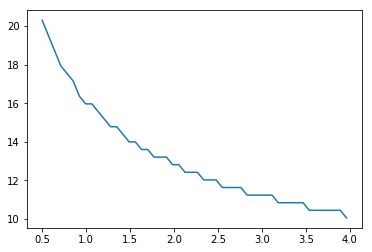

In [86]:
minimums = [[], [], []]
for i in np.arange(0, 100, 2):
    index, minTime = min(enumerate(time[i::100]), key=operator.itemgetter(1))
    minimums[0].append(dist[i])
    minimums[1].append(ratio[index])
    minimums[2].append(minTime)
    
plt.plot(minimums[0], minimums[1])
plt.show()

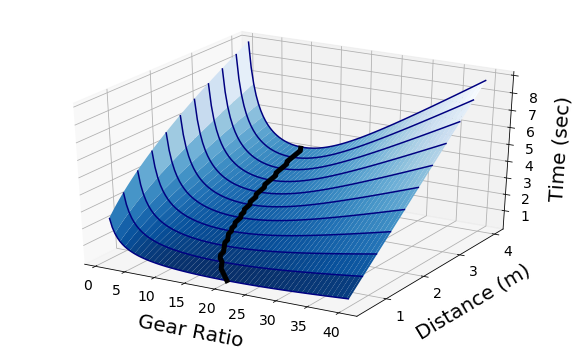

In [97]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(Y, X, Z, cmap=cm.Blues_r, cstride=10, rstride=2)
ax.plot_wireframe(Y, X, Z, antialiased=True, ccount=10, rcount=0, color='navy')
ax.plot(minimums[1], minimums[0], minimums[2], color='black', linestyle='solid', linewidth=5)

ax.set_ylabel('Distance (m)', fontsize=20, labelpad=14)
ax.set_xlabel('Gear Ratio', fontsize=20, labelpad=18)
ax.set_zlabel('Time (sec)', fontsize=20, labelpad=8)
#ax.set_title('%s  |  Mass = %.1f lbs' %(wheelType, mass*2.20462), fontsize=15)
plt.yticks(np.arange(1, 5, 1), fontsize=14)
plt.xticks(fontsize=14)
ax.set_zticklabels([1, 2, 3, 4, 5, 6, 7, 8], fontsize=14)

#filename = '3d_graphs/%s - m=%.1f lbs, nm=%d.png' %(wheelType, mass*2.20462, motor_num)
plt.savefig('Example_2.png', format='png', )
plt.show()


# Acceleration With Mass

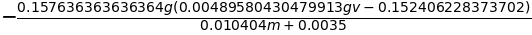

In [320]:
acelMassExp

In [ ]:
dist = 1.5 # meters

def acelMass(targetDist, ratio, mass):
    

# Auto Generating Graphs

In [17]:
def generate_2d_graph(ma, num, eff):
    global FVAL
    global SVAL
    
    
    # Motor Specs
    stall_torque = 4.2 / 40 # Stall torque (Nm)
    motor_num = num # Number of motors
    stall_current = 8.5 # Stall current (amps)
    no_load_current = 0.2 # No load current (amps)
    nominal_voltage = 12 #Nominal voltage (volts)
    free_speed = 150 * 40 # Free motor speed (rpm)

    # Robot Specs
    mass = 0.453592 * ma # Robot mass (kg)
    radius = .102 # Wheel diameter (m)
    inertia = 0.005 # Wheel inertia (Kg m^2)
    wheel_efficiency = eff # Wheel efficiency (Mecanum = 0.7, tank = 1)

    # Battery Specs
    batery_resistance = 0.1 # Battery Resistance (ohms)
    operating_voltage = 12.7 # Operating battery voltage (volts)
    
    
    subList = [(Ts, stall_torque), (nm, motor_num), (Is, stall_current), (Io, no_load_current), 
                     (Vm, nominal_voltage), (wo, free_speed), (rw, radius), (rb, batery_resistance), 
                     (E, wheel_efficiency), (Vo, operating_voltage), (Iw, inertia), (m, mass)]
    acelExp = workingAcel3.subs(subList)

    if wheel_efficiency == 1:
        wheelType = 'Tank Drive'
    elif wheel_efficiency == 0.7:
        wheelType = 'Mecanum Drive'
    else:
        wheelType = '' + 100 * wheel_efficiency + '% efficiency'

        
    FCOMP, SCOMP = acelExp.expand().args
    FVAL = float(FCOMP.subs(g, 1))
    SVAL = float(SCOMP.subs([(g, 1), (v, 1)]))

    
    
    minRatio = 1
    maxRatio = 40
    targetDist = [0.8, 1, 1.5, 2.5] # meters


    colors = cycle(["black", "blue", "grey", "silver", "lime", "green", "olive"])
    fig = plt.figure()
    ax = fig.add_subplot(111)

    ratios = np.arange(minRatio, maxRatio, .1)

    for dist in targetDist:
        time = [timeAtRatio(dist, x) for x in ratios]

        index, minTime = min(enumerate(time), key=operator.itemgetter(1))
        minRatio = ratios[index]
        color = next(colors)

        label = '%.1fm, Min: %.1f (%.3fs)' %(dist, minRatio, minTime)
        ax.plot(ratios, time, label=label, color=color)
        ax.plot(minRatio, minTime, '-o', color=color)


    ax.set_xlabel("Gear Reduction", fontsize=15)
    ax.set_ylabel("Time", fontsize=18)
    ax.legend(loc="best")
    ax.set_title('%s  |  Mass = %.1f lbs' %(wheelType, mass*2.20462), fontsize=13)
    ax.margins(0.1)
    fig.tight_layout()
    
    
    filename = '2d_graphs/%s - m=%.1f lbs, nm=%d.png' %(wheelType, mass*2.20462, motor_num)
    plt.savefig(filename, format='png')
    plt.show()


In [18]:
def generate_3d_graph(ma, num, eff):
    global FVAL
    global SVAL

    
    # Motor Specs
    stall_torque = 4.2 / 40 # Stall torque (Nm)
    motor_num = num # Number of motors
    stall_current = 8.5 # Stall current (amps)
    no_load_current = 0.2 # No load current (amps)
    nominal_voltage = 12 #Nominal voltage (volts)
    free_speed = 150 * 40 # Free motor speed (rpm)

    # Robot Specs
    mass = 0.453592 * ma # Robot mass (kg)
    radius = .102 # Wheel diameter (m)
    inertia = 0.005 # Wheel inertia (Kg m^2)
    wheel_efficiency = eff # Wheel efficiency (Mecanum = 0.7, tank = 1)

    # Battery Specs
    batery_resistance = 0.1 # Battery Resistance (ohms)
    operating_voltage = 12.7 # Operating battery voltage (volts)
    
    
    subList = [(Ts, stall_torque), (nm, motor_num), (Is, stall_current), (Io, no_load_current), 
                     (Vm, nominal_voltage), (wo, free_speed), (rw, radius), (rb, batery_resistance), 
                     (E, wheel_efficiency), (Vo, operating_voltage), (Iw, inertia), (m, mass)]
    acelExp = workingAcel3.subs(subList)

    if wheel_efficiency == 1:
        wheelType = 'Tank Drive'
    elif wheel_efficiency == 0.7:
        wheelType = 'Mecanum Drive'
    else:
        wheelType = '' + 100 * wheel_efficiency + '% efficiency'

        
    FCOMP, SCOMP = acelExp.expand().args
    FVAL = float(FCOMP.subs(g, 1))
    SVAL = float(SCOMP.subs([(g, 1), (v, 1)]))

    
    ratio = np.linspace(1, 40, 100)
    dist = np.linspace(0.5, 4, 100)

    X, Y = np.meshgrid(dist, ratio)

    time = []
    for x, y in zip(np.ravel(X), np.ravel(Y)):
        val = timeAtRatio(x, y)
        time.append(val)
        #print('(%.2f, %.2f): %.3f' %(x, y, val))

    nptime = np.array(time)
    #time = np.array([timeAtRatio(x,y) for x,y in zip(np.ravel(X), np.ravel(Y))])

    Z = nptime.reshape(X.shape)
    
    minimums = [[], [], []]
    for i in np.arange(0, 100, 2):
        index, minTime = min(enumerate(time[i::100]), key=operator.itemgetter(1))
        minimums[0].append(dist[i])
        minimums[1].append(ratio[index])
        minimums[2].append(minTime)

    
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.plot_surface(Y, X, Z, cmap=cm.Blues_r, cstride=10, rstride=2)
    ax.plot_wireframe(Y, X, Z, antialiased=True, ccount=10, rcount=0, color='navy')
    ax.plot(minimums[1], minimums[0], minimums[2], color='black', linestyle='solid', linewidth=5)

    ax.set_ylabel('Distance (m)', fontsize=12)
    ax.set_xlabel('Gear Ratio', fontsize=12)
    ax.set_zlabel('Time (sec)', fontsize=12)
    ax.set_title('%s  |  Mass = %.1f lbs' %(wheelType, mass*2.20462), fontsize=15)
    plt.yticks(np.arange(1, 5, 1))

    filename = '3d_graphs/%s - m=%.1f lbs, nm=%d.png' %(wheelType, mass*2.20462, motor_num)
    plt.savefig(filename, format='png')
    plt.show()


executing  (15, 2, 0.7)


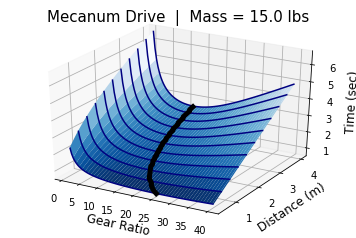

executing  (15, 2, 1)


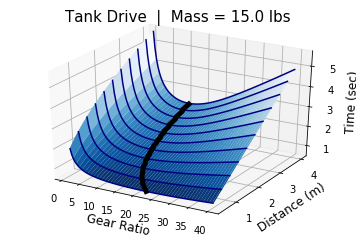

executing  (15, 4, 0.7)


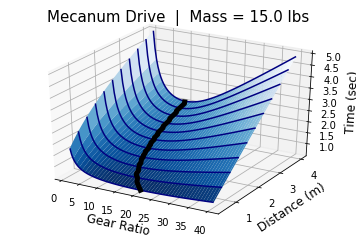

executing  (15, 4, 1)


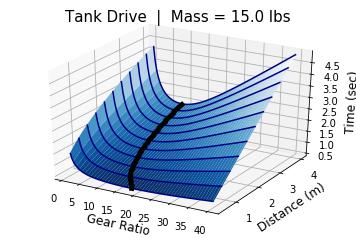

executing  (15, 6, 0.7)


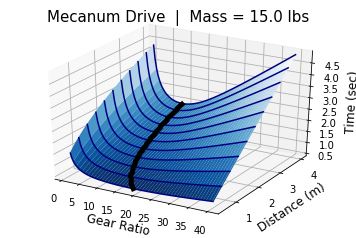

executing  (15, 6, 1)


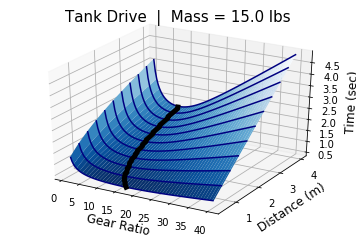

executing  (20, 2, 0.7)


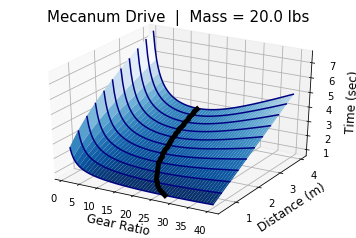

executing  (20, 2, 1)


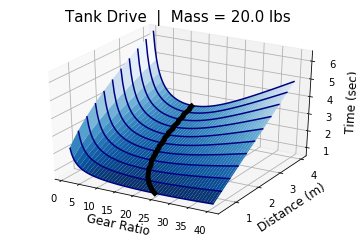

executing  (20, 4, 0.7)


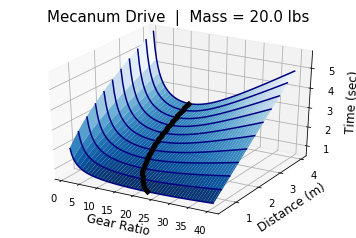

executing  (20, 4, 1)


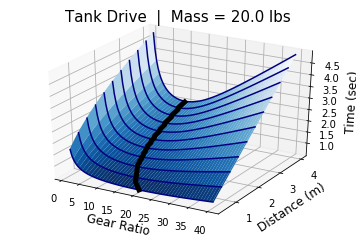

executing  (20, 6, 0.7)


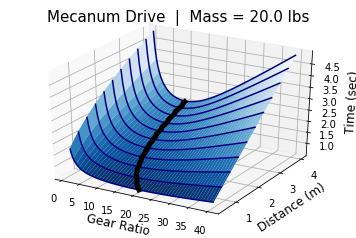

executing  (20, 6, 1)


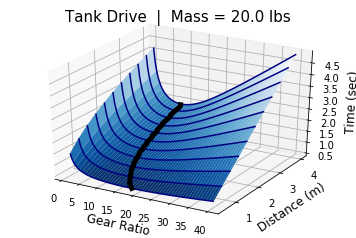

executing  (25, 2, 0.7)


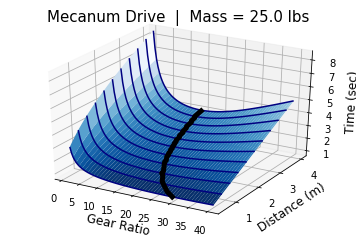

executing  (25, 2, 1)


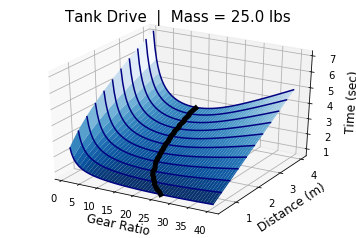

executing  (25, 4, 0.7)


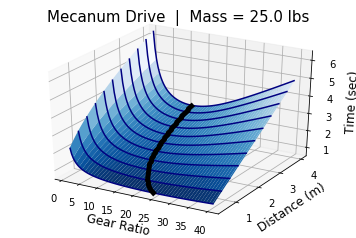

executing  (25, 4, 1)


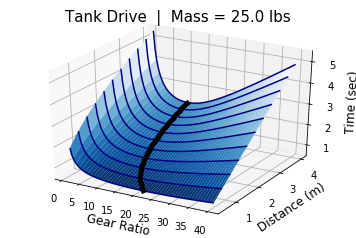

executing  (25, 6, 0.7)


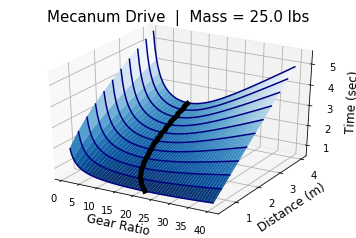

executing  (25, 6, 1)


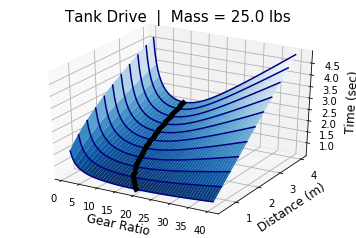

executing  (30, 2, 0.7)


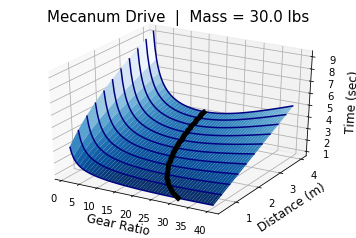

executing  (30, 2, 1)


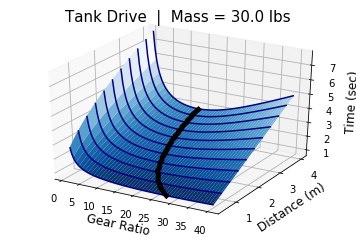

executing  (30, 4, 0.7)


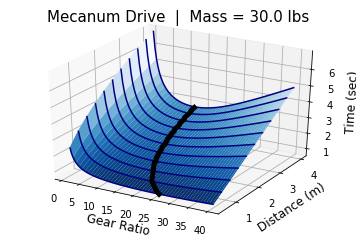

executing  (30, 4, 1)


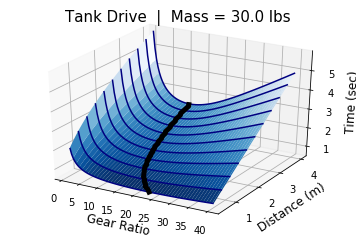

executing  (30, 6, 0.7)


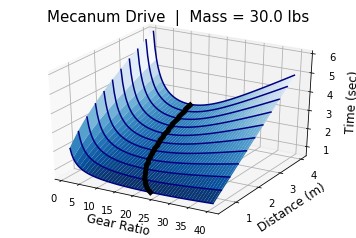

executing  (30, 6, 1)


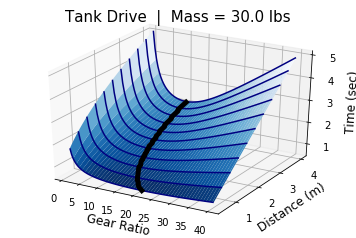

executing  (35, 2, 0.7)


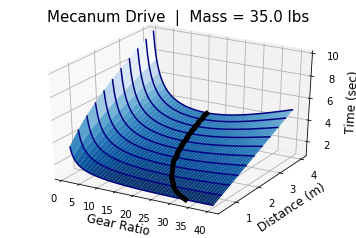

executing  (35, 2, 1)


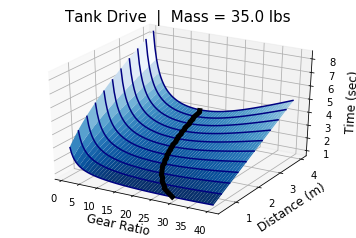

executing  (35, 4, 0.7)


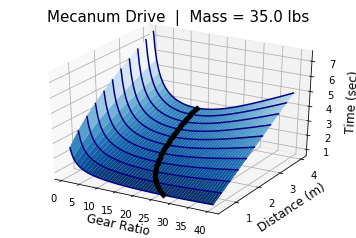

executing  (35, 4, 1)


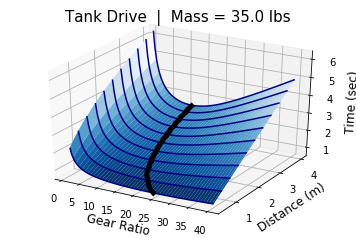

executing  (35, 6, 0.7)


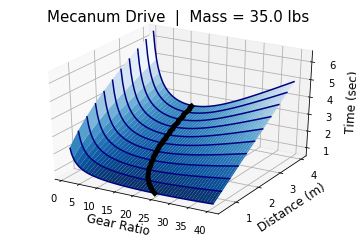

executing  (35, 6, 1)


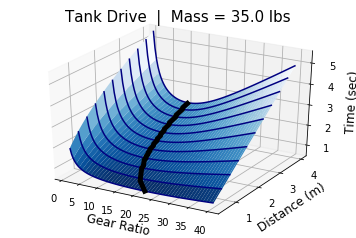

executing  (40, 2, 0.7)


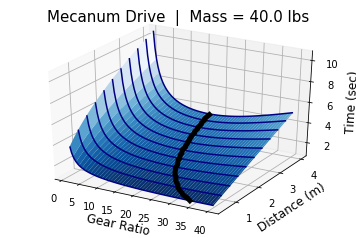

executing  (40, 2, 1)


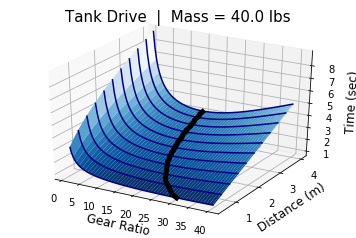

executing  (40, 4, 0.7)


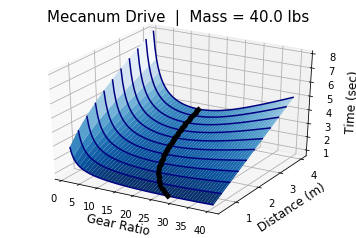

executing  (40, 4, 1)


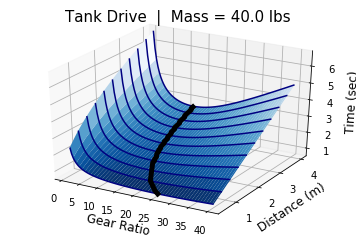

executing  (40, 6, 0.7)


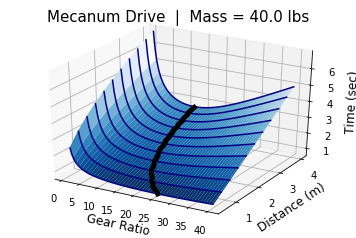

executing  (40, 6, 1)


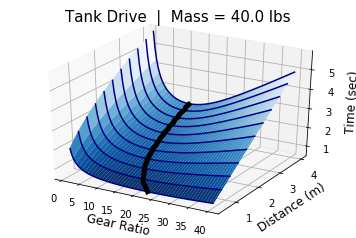

executing  (42, 2, 0.7)


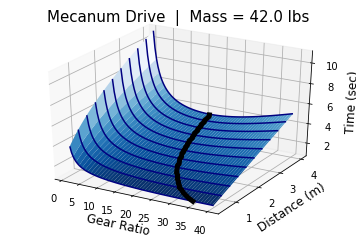

executing  (42, 2, 1)


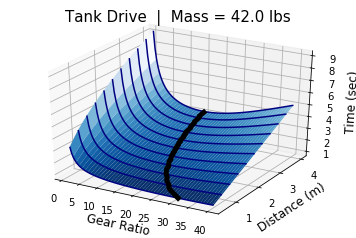

executing  (42, 4, 0.7)


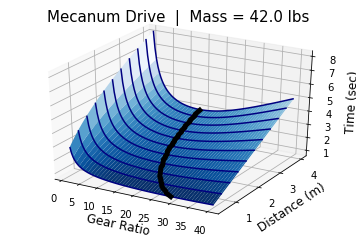

executing  (42, 4, 1)


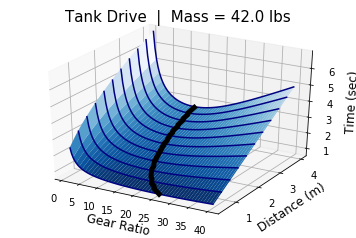

executing  (42, 6, 0.7)


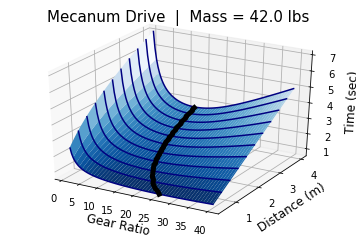

executing  (42, 6, 1)


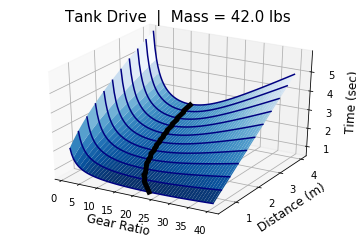

In [88]:
masses = [15, 20, 25, 30, 35, 40, 42]
motorNums = [2, 4, 6]
wheelEfficiencies = [0.7, 1]

for i in masses:
    for j in motorNums:
        for k in wheelEfficiencies:
            print('executing ', repr((i, j, k)))
            generate_3d_graph(i, j, k)